In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from prfpy_csenf.csenf_plot_functions import *
from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.prfpy_ts_plotter import *
from dag_prf_utils.plot_functions import *
from dag_prf_utils.utils import *
from dag_prf_utils.pycortex import *


from amb_scripts.load_saved_info import *
from amb_scripts.plot_functions import *
plot_cols = get_plot_cols()

p2plot_nice = {
    'nothingrois' : 'ROI borders',
    'sfmax': 'SF_{max} (c/deg)',
    'aulcsf': 'normalized AUC (%)',
    'SFp': 'SF_p (c/deg)',
    'CSp': 'CS_p (a.u.)',
    'crf_exp': 'slope_{crf} (a.u.)',
    'rsq' : 'variance explained (%)',
    'ecc' : 'eccentricity (deg)',
    'size_1' : 'size',
}

sub_list = ['sub-02',] # 'sub-02', 'sub-03']
ses_list = ['ses-1', 'ses-2']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Number of timepoints: 214
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]


sub-02 only

[1] ecc vs size. 2 x 3 (ses 1,3, roi V1,V2,V3)

[2] Time series gauss. LE & RE. V1 (+color)

[3] Surfaces ses - eye - ecc,pol,PRF rsq

[4] qCSF Before & after 

...
[5] ncsf 



In [2]:
from figure_finder.figure_saver import FigureSaver
from figure_finder.utils import save_running_code

fig_saver = FigureSaver(
    name='EMC_report_2024-26-11',
    path='/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/notebook_timeline/',
    fig_overwrite='ow',   
    save_mode       = True, 
    save_svg        = False,
    save_svg_basic  = True,
    save_png        = True,
    save_pdf        = True,
    folder_ow       = False,

)

save_running_code(opj(fig_saver.path))

Making folder


<IPython.core.display.Javascript object>

Notebook not saving...
jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/r0_reports/r0_EMC_figures.ipynb --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/notebook_timeline/EMC_report_2024-26-11/r0_EMC_figures.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/r0_reports/r0_EMC_figures.ipynb to html
[NbConvertApp] Writing 1500213 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/notebook_timeline/EMC_report_2024-26-11/r0_EMC_figures.html


jupyter nbconvert --to html /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/r0_reports/r0_EMC_figures.ipynb --no-input --output /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/notebook_timeline/EMC_report_2024-26-11/r0_EMC_figures_NOCODE.html


[NbConvertApp] Converting notebook /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/r0_reports/r0_EMC_figures.ipynb to html
[NbConvertApp] Writing 1394694 bytes to /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/notebook_timeline/EMC_report_2024-26-11/r0_EMC_figures_NOCODE.html


# Load saved info

#### Load qCSF

In [3]:

qCSF_info = {}
for sub in sub_list:
    qCSF_info[sub] = {}
    for ses in ses_list:
        try: 
            qCSF_info[sub][ses] = amb_load_qcsf(sub, eye_list=['L', 'R'], ses=ses)
        except:
            print(f'failed {sub} {ses}')
            qCSF_info[sub][ses] = []


#### Load run correlation (akin to rsq ceiling)

In [3]:
run_corr = {}
for sub in sub_list:
    run_corr[sub] = {}
    for i_ses,ses in enumerate(ses_list):   
        for model in ['gauss', 'csf']:
            for eye in ['L', 'R']:
                if model=='gauss':
                    task = f'pRF{eye}E'
                else:
                    task = f'CSF{eye}E'
                try:
                    run_corr[sub][f'{eye}_{i_ses+1}_{model}'] = amb_load_run_corr(
                        sub=sub,
                        task_list=task,
                        ses=ses,
                    )[task]
                except:                
                    run_corr[sub][f'{eye}_{i_ses+1}_{model}'] = []
                    print(f'{sub} {task} failed')

In [4]:
# Load prfpy_stim
prfpy_stim = {}
prfpy_stim['gauss'] = amb_load_prfpy_stim('pRF')
prfpy_stim['csf'] = amb_load_prfpy_stim('CSF')

prfpy_model = {}
prfpy_model['gauss'] = Iso2DGaussianModel(stimulus=prfpy_stim['gauss'])
prfpy_model['csf'] = CSenFModel(stimulus=prfpy_stim['csf'])
prfpy_model['csf_bin'] = CSenFModel(stimulus=prfpy_stim['csf'], edge_type='binary')

Number of timepoints: 214
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]


In [5]:
roi_fit = 'all'
fit_stage='iter'

model_list = ['gauss', 'csf']
prf_multi = {}

for sub in sub_list:
    prf_obj_list = [] 
    prf_id_list = []
    for i_ses,ses in enumerate(ses_list):        
        for eye in ['L', 'R']:    
            for model in model_list:
                if 'csf' in model:
                    task = f'CSF{eye}E'
                else:
                    task = f'pRF{eye}E'
                try:
                    this_prf_data = amb_load_prf_params(
                        sub=sub,
                        task_list=task,
                        model_list=model,
                        roi_fit=roi_fit, 
                        fit_stage=fit_stage,
                        ses=ses
                    )[task][model]
                    this_real_ts = amb_load_real_tc(sub=sub, task_list=task, ses=ses)[task]
                    

                    if model=='csf':
                        this_obj = CSenFPlotter(
                            prf_params=this_prf_data,
                            real_ts = this_real_ts,                        
                            prfpy_model = prfpy_model['csf'],
                        )
                    else:
                        this_obj = TSPlotter(
                            prf_params=this_prf_data,
                            real_ts = this_real_ts,                        
                            model='gauss',
                            prfpy_model = prfpy_model['gauss'],
                        )

                    prf_obj_list.append(this_obj)
                    prf_id_list.append(f'{eye}_{i_ses+1}_{model}')
                except:
                    print(f'FAILED FOR {eye}_{i_ses+1}_{model}')
            
    prf_multi[sub] = PrfMulti(prf_obj_list, prf_id_list)

prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=10
hrf=params[:,7,8]
rsq=params[:,9]
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=10
hrf=params[:,7,8]
rsq=params[:,9]
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=10
hrf=params[:,7,8]
rsq=params[:,9]
prf_params.shape[-1]=8
include hrf = True
include rsq = True
prf_params.shape[-1]=10
hrf=params[:,7,8]
rsq=params[:,9]


# STATS

(1.0, 80.0)

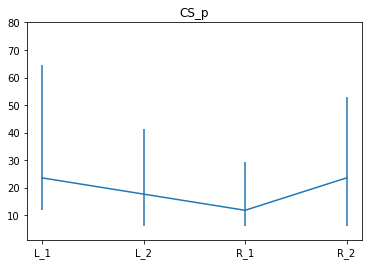

In [67]:
min_rsq = 0.3
max_ecc = 5
p = 'csf-CSp'
roi = 'b14_V1'
mdict = {}
udict = {}
ldict = {}
m = []
u = []
l = []
labels = []
for e in ['L', 'R']:    
    mdict[e] = {}
    udict[e] = {}
    ldict[e] = {}
    for s in ['1', '2']:
        vx_mask = prf_multi['sub-02'].return_vx_mask(th={
            f'{e}_{s}_gauss-min-rsq': min_rsq,
            f'{e}_{s}_gauss-max-ecc': max_ecc,
            f'{e}_{s}_csf-min-rsq': min_rsq,
            'roi' : amb_load_roi(sub, roi),
        })
        this_p = prf_multi['sub-02'].pd_params[f'{e}_{s}_{p}'][vx_mask].to_numpy()
        mdict[e][s] = np.nanmedian(this_p)
        udict[e][s] = np.nanpercentile(this_p, 75)
        ldict[e][s] = np.nanpercentile(this_p, 25)
        m.append(np.nanmedian(this_p))
        u.append(np.nanpercentile(this_p, 75))
        l.append(np.nanpercentile(this_p, 25))
        labels.append(f'{e}_{s}')

from dag_prf_utils.plot_functions import *
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.errorbar(labels, m, yerr=[l, u], )#, fmt='o')
ax.set_title('CS_p')

# dag_group_and_individual_2dict(
#     ax=ax,
#     mdict=mdict,
#     y_upper=udict,
#     y_lower=ldict,

# )

ax.set_ylim(1, 80)
# ax.set_yscale('log')


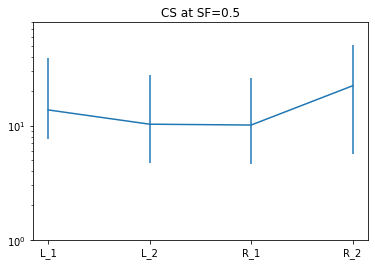

In [94]:
# Get CSp at lowest sf=0.5
from prfpy_csenf.rf import asymmetric_parabolic_CSF


min_rsq = 0.3
max_ecc = 5

roi = 'b14_V1'
mdict = {}
udict = {}
ldict = {}
m = []
u = []
l = []
labels = []
for e in ['L', 'R']:    
    mdict[e] = {}
    udict[e] = {}
    ldict[e] = {}
    for s in ['1', '2']:
        vx_mask = prf_multi['sub-02'].return_vx_mask(th={
            f'{e}_{s}_gauss-min-rsq': min_rsq,
            f'{e}_{s}_gauss-max-ecc': max_ecc,
            f'{e}_{s}_csf-min-rsq': min_rsq,
            'roi' : amb_load_roi('sub-02', roi, combine_matches=True),
        })
        this_p = asymmetric_parabolic_CSF(
            SF_seq=[0, 0.5],
            **prf_multi['sub-02'].prf_obj[f'{e}_{s}_csf'].pd_params.iloc[vx_mask].to_dict('list'),
        )[:,1]
        
        mdict[e][s] = np.nanmedian(this_p)
        udict[e][s] = np.nanpercentile(this_p, 75)
        ldict[e][s] = np.nanpercentile(this_p, 25)
        m.append(np.nanmedian(this_p))
        u.append(np.nanpercentile(this_p, 75))
        l.append(np.nanpercentile(this_p, 25))
        labels.append(f'{e}_{s}')

from dag_prf_utils.plot_functions import *
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.errorbar(labels, m, yerr=[l, u], )#, fmt='o')
ax.set_title('CS at SF=0.5')

# dag_group_and_individual_2dict(
#     ax=ax,
#     mdict=mdict,
#     y_upper=udict,
#     y_lower=ldict,

# )

ax.set_ylim(1, 80)
ax.set_yscale('log')
plt.show()


In [77]:
prf_multi['sub-02'].prf_obj['L_1_csf'].pd_params.iloc[vx_mask].to_dict('list')

{'width_r': [0.0,
  1.5,
  0.42857142857142855,
  1.3104818952912198,
  1.2722629153748417,
  0.6249731942441051,
  0.7049098972069557,
  0.6729780236556013,
  0.8513828140814209,
  0.8883868203567321,
  1.0328599745621638,
  0.837880258831594,
  0.8590278330788014,
  0.6609576373164906,
  0.7406484741250576,
  0.9650940864419915,
  0.852600103503872,
  0.8571428571428571,
  1.042196884486961,
  1.5,
  1.5,
  1.5,
  1.2875439544825462,
  1.2862685529333544,
  1.2074309302657134,
  0.8924291928352757,
  0.7509766911877382,
  1.2857142857142856,
  1.3250184028857306,
  1.2865403567938916,
  1.2745729725176813,
  1.5,
  1.2938060450468196,
  1.5,
  1.0933296003804178,
  0.8323360932833891,
  1.5,
  1.5,
  1.2964509185679076,
  1.5,
  1.0162606208897482,
  1.2718144208694855,
  1.0483933339827034,
  1.073575108619467,
  1.486248275544658,
  1.0934078126049807,
  1.3091409064198507,
  1.5,
  1.0714285714285714,
  1.0398404195997888,
  0.6631094757738634,
  1.5,
  1.5,
  1.2892266768190237,


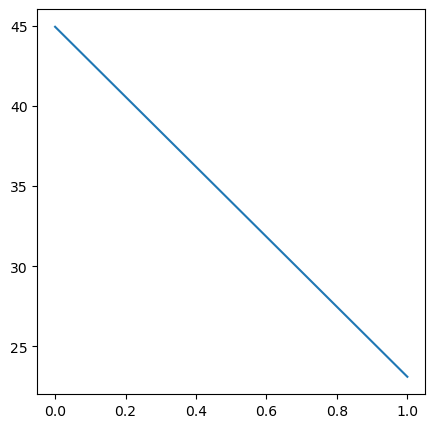

{'n': 93.42214532871972, 'mean_diff': 1.7299297596424532, 't_statistic': 0.5757126483852589, 'p_value': 0.5662085999527289, 'df': 92.42214532871972}


In [42]:
upsampling_factor = 1.7**2 / 0.7**2
from dag_prf_utils.stats import dag_paired_ttest
v1_mask = amb_load_roi('sub-02', 'b14_V1')
p_list = ['CSp']
min_rsq = 0.1
for p in p_list:
    e = 'L'
    this_p = []
    for s in ['1','2']:
        vx_mask = prf_multi['sub-02'].return_vx_mask(th={        
            f'{e}_{s}_gauss-min-rsq' : min_rsq, 
            f'{e}_{s}_gauss-max-ecc' : 5,         
            f'{e}_{s}_csf-min-rsq' : min_rsq,  
            'roi' : v1_mask, 
        }
        )
        this_p.append(
            prf_multi['sub-02'].pd_params[f'{e}_{s}_csf-CSp'][vx_mask].to_numpy().mean()
        )
    # print(vx_mask.sum())
    # p1 = prf_multi['sub-02'].pd_params[f'{e}_1_csf-CSp'][vx_mask].to_numpy()
    # p2 = prf_multi['sub-02'].pd_params[f'{e}_2_csf-CSp'][vx_mask].to_numpy()
    # plt.scatter(p1, p2)
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    # ax.hist(p1, color='r', alpha=0.5)    
    # ax.hist(p2, color='b', alpha=0.5)
    ax.plot(this_p) #[p1.mean(), p2.mean()])
    # equal axis
    # plt.gca().set_xscale('log')
    # plt.gca().set_yscale('log')
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    # diff_stats = dag_paired_ttest(p1, p2, upsampling_factor=upsampling_factor)
    print(diff_stats)

In [10]:
prf_multi['sub-02'].id_list

['L_1_gauss',
 'L_1_csf',
 'R_1_gauss',
 'R_1_csf',
 'L_2_gauss',
 'L_2_csf',
 'R_2_gauss',
 'R_2_csf']

# ECC vs SIZE 

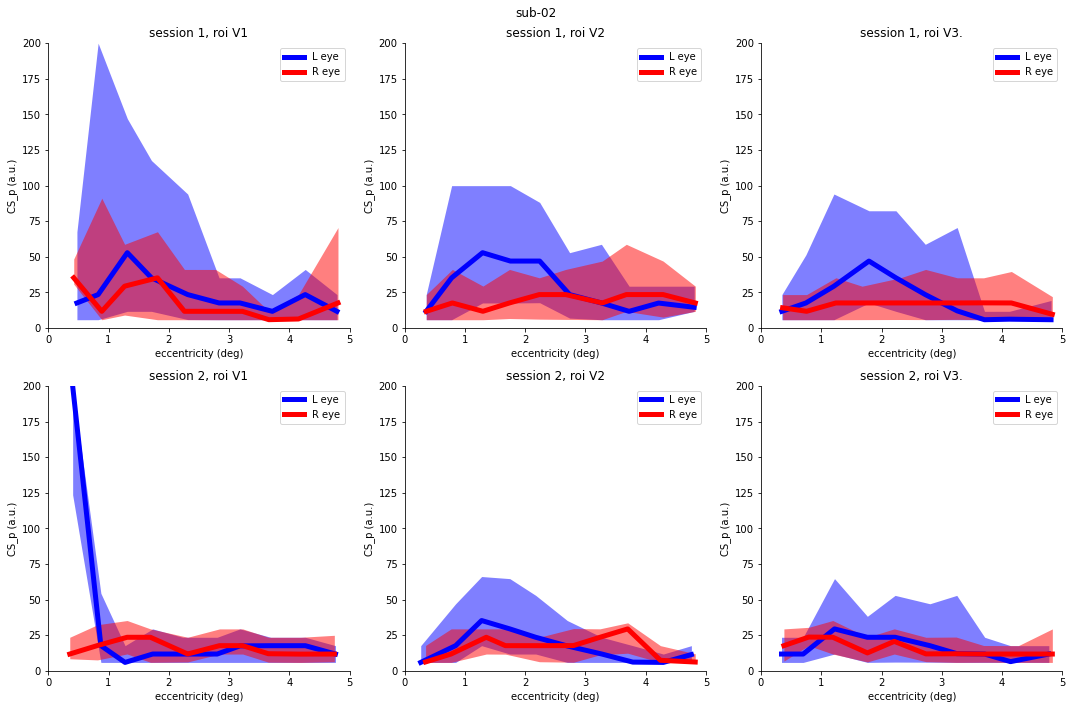

In [46]:
%matplotlib inline
# sns.set_context('paper')
min_rsq = 0.1
max_ecc = 5
y_lim = [0,5]
roi_list = ['b14_V1', 'b14_V2', 'b14_V3.']
# for y_param in ['gauss-size_1', 'csf-SFp', 'csf-CSp', 'csf-aulcsf']:
for y_param in ['csf-CSp']:
    for sub in ['sub-02']: # sub_list:
        fig,axs = plt.subplots(2,3)
        fig.set_size_inches(5*3,5*2)
        fig.suptitle(sub)

        for i_roi, roi in enumerate(roi_list):
            for i_ses, ses in enumerate(['1','2']):
                ax = axs[i_ses][i_roi]
                for i_eye, eye in enumerate(['L', 'R']):
                    # print(ses)
                    # print(roi)
                    roi_mask = amb_load_roi(sub, roi)

                    if f'{eye}_{ses}_gauss' not in prf_multi[sub].id_list:
                        continue
                    if (f'{eye}_{ses}_csf' not in prf_multi[sub].id_list) & ('csf' in y_param):
                        continue

                    if 'csf' in y_param:
                        th = {
                            f'{eye}_{ses}_gauss-min-rsq':min_rsq,
                            f'{eye}_{ses}_gauss-max-ecc':max_ecc,
                            f'{eye}_{ses}_csf-min-rsq':min_rsq,
                            'roi' : roi_mask,
                        }                        
                    else:
                        th = {
                            f'{eye}_{ses}_gauss-min-rsq':min_rsq,
                            f'{eye}_{ses}_gauss-max-ecc':max_ecc,
                            'roi' : roi_mask,
                        }
                    prf_multi[sub].scatter(
                        px=f'{eye}_{ses}_gauss-ecc',
                        py=f'{eye}_{ses}_{y_param}',
                        do_line=True,
                        bins=np.linspace(0,5,11),
                        do_scatter=False,
                        ax=ax,
                        line_label=f'{eye} eye',
                        th=th,
                        # th_plus={'roi':roi_mask},
                        line_col = plot_cols[f'{eye}E'],
                        x_lim=[0,5],
                        y_lim=y_lim,
                        do_bars=False, 
                        do_shade=True, 
                        err_type='pc-75'
                    )
                    ax.set_title(f'session {ses}, roi {roi.replace("b14_", "")}')
                    # ax.set_yscale('log')
                    # ax.set_aspect('equal')
                    # ax.set_axis('square') # change to be square
                    ax.set_xlabel(f'{p2plot_nice["ecc"]}')
                    ax.set_ylabel(f'{p2plot_nice[y_param.split("-")[-1]]}')
                    # ncsf_plt_fix_ecc_ax(ax, p=y_param.split("-")[-1])
                    # ax.set_xlim(0,200)
                    ax.set_ylim(0,200)
        fig.set_tight_layout('tight')

        # fig_saver.add_img(fig, f'ECC_PLOT_{sub}-ecc_vs_{y_param}', ow=True)

# TIMESERIES

<Figure size 432x288 with 0 Axes>

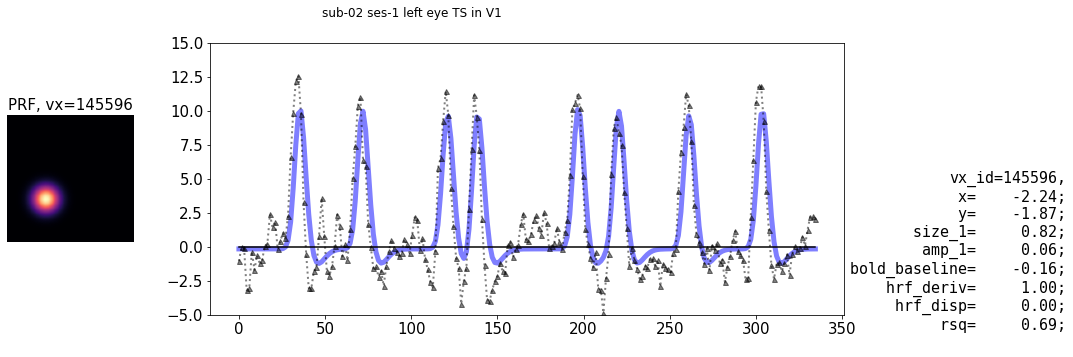

<Figure size 432x288 with 0 Axes>

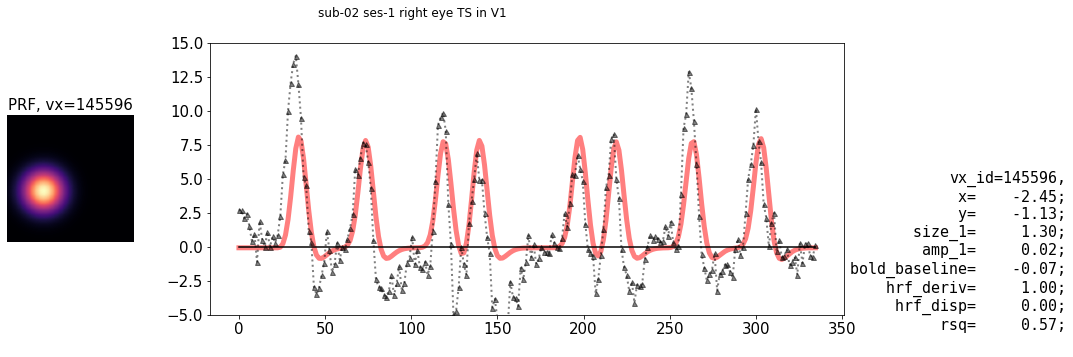

In [8]:
# Find nice voxel...
# roi = 'b14_V1'
# min_rsq = 0.4
# roi_mask = amb_load_roi(sub, roi)
# vx_mask = prf_multi[sub].return_vx_mask({
#     'L_1_csf-min-rsq'       : min_rsq,
#     'L_1_gauss-min-rsq'     : min_rsq,
#     'L_1_gauss-bound-ecc'   : [0.5,3],
#     'R_1_csf-min-rsq'       : min_rsq,
#     'R_1_gauss-min-rsq'     : min_rsq,
#     'R_1_gauss-bound-ecc'   : [0.5,3],
#     'roi'           : roi_mask,
# })  

# print(np.where(vx_mask))
idx = 145596
fig = plt.figure()
prf_multi[sub].prf_obj['L_1_gauss'].prf_ts_plot(
    idx, ts_kwargs=dict(color=plot_cols['LE']))
fig =plt.gcf()
ts_ax = fig.get_children()[2]
ts_ax.set_ylim(-5,15)
fig.suptitle(f'{sub} ses-1 left eye TS in V1')
fig_saver.add_img(fig, f'TS_PLOT_{sub}-LE_timeseries')

fig = plt.figure()
prf_multi[sub].prf_obj['R_1_gauss'].prf_ts_plot(
    idx, ts_kwargs=dict(color=plot_cols['RE']))
fig =plt.gcf()
ts_ax = fig.get_children()[2]
ts_ax.set_ylim(-5,15)
fig.suptitle(f'{sub} ses-1 right eye TS in V1')
fig_saver.add_img(fig, f'TS_PLOT_{sub}-RE_timeseries')


# QCSF

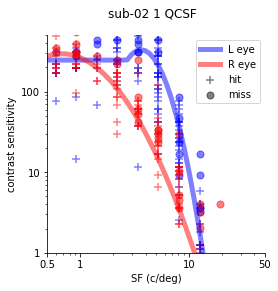

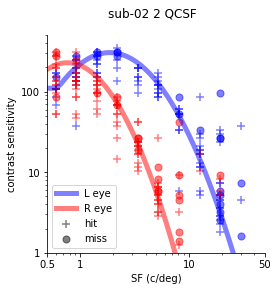

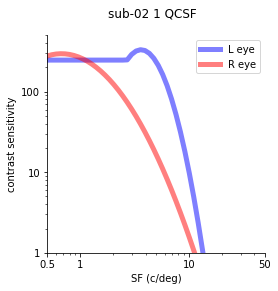

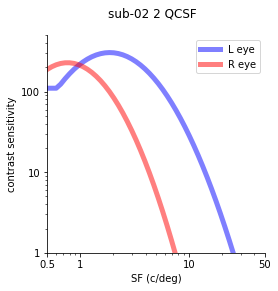

In [9]:
# Find nice voxel...

for sub in sub_list:
    for i_ses,ses in enumerate([1, 2]):
        fig,ax = plt.subplots(1)
        fig.set_size_inches(4,4)
        fig.suptitle(f'{sub} {ses} QCSF')
        for eye in ['L', 'R']: # , 'R']:
            ncsf_plt_qCSF(
                qCSF_info[sub][f'ses-{ses}'][eye],
                ax=ax,
                line_label=f'{eye} eye',
                line_col=plot_cols[f'{eye}E'],
                do_response=True, 
            )
        ax.scatter(.1, .1, s=50, color='k', marker='+', alpha=0.5, label='hit')
        ax.scatter(.1, .1, s=50, color='k', marker='o', alpha=0.5, label='miss')

        plt.legend()
        fig_saver.add_img(fig, f'QCSF_PLOT_{sub}-{ses}_hitmiss')


for sub in sub_list:
    for i_ses,ses in enumerate([1, 2]):
        fig,ax = plt.subplots(1)
        fig.set_size_inches(4,4)
        fig.suptitle(f'{sub} {ses} QCSF')
        for eye in ['L', 'R']: # , 'R']:
            ncsf_plt_qCSF(
                qCSF_info[sub][f'ses-{ses}'][eye],
                ax=ax,
                line_label=f'{eye} eye',
                line_col=plot_cols[f'{eye}E'],
                do_response=False, 
            )
        ax.set_box_aspect(1)
        plt.legend()
        fig_saver.add_img(fig, f'QCSF_PLOT_{sub}-{ses}_line_only')        
plt.show()

# NCSF 

298
108
354
276
395
244
244
60
456
137
530
225


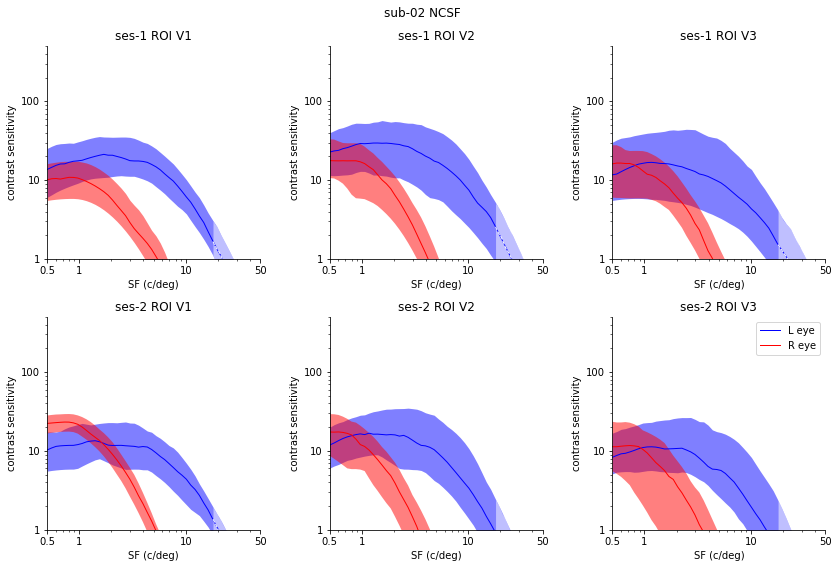

In [96]:
# Find nice voxel...
roi_list = ['b14_V1', 'b14_V2', 'b14_V3.']
min_rsq = 0.3
max_ecc = 5

for sub in sub_list:
    fig,axs = plt.subplots(2,3)
    fig.set_size_inches(12,8)
    fig.suptitle(f'{sub} NCSF')
    
    for i_ses,ses in enumerate([1, 2]):
        for i_roi,roi in enumerate(roi_list): 
            roi_mask = amb_load_roi(sub, roi)            
            for eye in ['L', 'R']: # , 'R']:
                vx_mask = prf_multi[sub].return_vx_mask({
                    f'{eye}_{ses}_csf-min-rsq'          : min_rsq,
                    f'{eye}_{ses}_gauss-min-rsq'        : min_rsq,
                    f'{eye}_{ses}_gauss-max-ecc'        : max_ecc,
                    'roi'           : roi_mask,
                })  
                print(vx_mask.sum())
                params = prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].pd_params.iloc[vx_mask]

                ncsfplt_csf_curve(
                    ax=axs[i_ses][i_roi],
                    params=params, 
                    line_label=f'{eye} eye',
                    line_col=plot_cols[f'{eye}E'],
                )
                nice_roi = roi.replace('b14_', '').replace('.', '')
                axs[i_ses][i_roi].set_title(f'ses-{ses} ROI {nice_roi}')
    axs[i_ses][i_roi].legend()
    fig.set_tight_layout('tight')
    fig_saver.add_img(fig, f'NCSF_PLOT_{sub}')      
plt.show()

### Split by eye, same ax for session

298
108
354
276
395
244
244
60
456
137
530
225


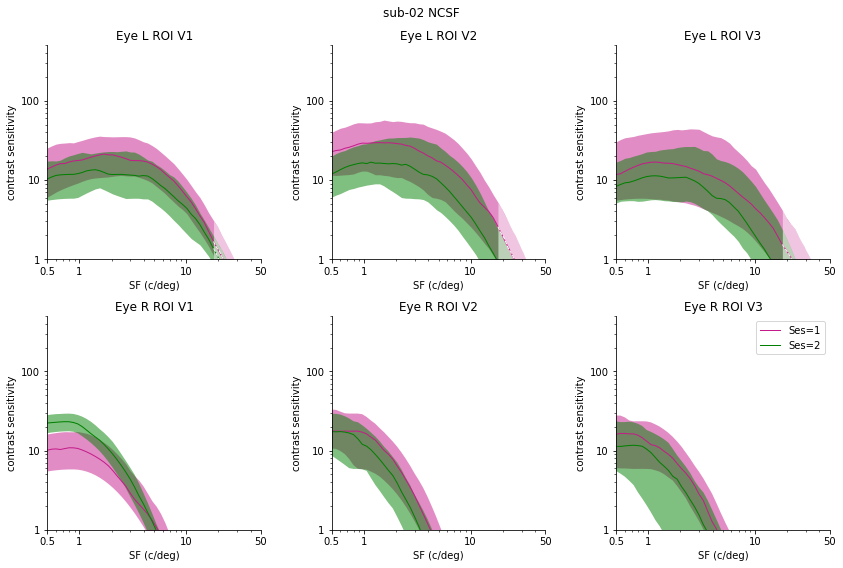

In [ ]:
# Find nice voxel...
roi_list = ['b14_V1', 'b14_V2', 'b14_V3.']
min_rsq = 0.3
max_ecc = 5

for sub in sub_list:
    fig,axs = plt.subplots(2,3)
    fig.set_size_inches(12,8)
    fig.suptitle(f'{sub} NCSF')
    
    for i_ses,ses in enumerate([1, 2]):
        for i_roi,roi in enumerate(roi_list): 
            roi_mask = amb_load_roi(sub, roi)            
            for i_eye,eye in enumerate(['L', 'R']): # , 'R']:
                vx_mask = prf_multi[sub].return_vx_mask({
                    f'{eye}_{ses}_csf-min-rsq'          : min_rsq,
                    f'{eye}_{ses}_gauss-min-rsq'        : min_rsq,
                    f'{eye}_{ses}_gauss-max-ecc'        : max_ecc,
                    'roi'           : roi_mask,
                })  
                print(vx_mask.sum())
                params = prf_multi[sub].prf_obj[f'{eye}_{ses}_csf'].pd_params.iloc[vx_mask]
                ses_cols = {
                    1 : '#c51b8a',
                    2 : 'g',
                }
                ncsfplt_csf_curve(
                    ax=axs[i_eye][i_roi],
                    params=params, 
                    line_label=f'Ses={ses}',
                    line_col=ses_cols[ses],
                )
                nice_roi = roi.replace('b14_', '').replace('.', '')
                axs[i_eye][i_roi].set_title(f'Eye {eye} ROI {nice_roi}')
    axs[i_ses][i_roi].legend()
    fig.set_tight_layout('tight')
    fig_saver.add_img(fig, f'NCSF_PLOT_SPLIT_EYE{sub}')      
plt.show()

# SURFACES

In [22]:
# START LOGGING THIS NOTEBOOK

p_cmap = {
    'crf_exp'   : 'cool_log', 
    'SFp'       : 'viridis',
    'aulcsf'    : 'aulcsf', 
    'rsq'       : 'plasma',
    'ecc'       : 'ecc2', #'ecc2', 
    'pol'       : 'marco_pol',
    'size_1'    : 'viridis_log',
    'CSp'       : 'viridis_log',        
    'sfmax'       : 'viridis_log',
    'corr'      : 'RdBu_r',

}
p_bounds = {
    'SFp'     : [0,3],
    'crf_exp' : [.1, 5],
    'aulcsf'  : [0,150],
    'rsq'     : [0.1,1],
    'ecc'     : [0,5],
    'pol'     : [-np.pi, np.pi],    
    'size_1'   : [0, 5],
    'sfmax'   : [0, 50],
    'CSp'  : [0, 100],
    'corr' : [-1,1],
}
roi_list = ['b14_V1', 'b14_V2', 'b14_V3.', 'b14_V3a', 'b14_V3b', 'b14_LO1', 'b14_LO2'] # 'all']
from dag_prf_utils.pycortex import *
# from linescanning.pycortex import *
set_ctx_path(
    p='/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/pycortex',
)


'/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/pycortex'

In [ ]:

p_list = ['gauss-ecc', 'gauss-pol', 'gauss-rsq', 'csf-rsq', 'csf-SFp', 'csf-aulcsf']    
for sub in sub_list:
    sub_pyc_file = opj(fig_saver.path, sub)
    if not os.path.exists(sub_pyc_file):
        os.mkdir(sub_pyc_file)
    pm = PyctxMaker(
        sub = sub,
        fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer',
        output_dir = sub_pyc_file,
        )
    for p_full in p_list:
        for ses in ['1', '2']:
            for eye in ['L', 'R']:
                p_mod, p_par = p_full.split('-')
                if p_mod=='csf':
                    th = {
                        f'{eye}_{ses}_csf-min-rsq':.1,
                        f'{eye}_{ses}_gauss-min-rsq':.1,
                        f'{eye}_{ses}_gauss-max-ecc':5,
                        }
                else:
                    th = {
                        f'{eye}_{ses}_gauss-min-rsq':.1,
                        f'{eye}_{ses}_gauss-max-ecc':5,
                        }

                full_param_keye = f'{eye}_{ses}_{p_mod}-{p_par}'
                if p_par=='corr':
                    data = run_corr[sub][f'{eye}_{ses}_{p_mod}']
                    vx_mask = np.ones_like(data, dtype=bool)
                else:
                    data = prf_multi[sub].pd_params[full_param_keye].to_numpy()
                    vx_mask = prf_multi[sub].return_vx_mask(th)
                surf_name = f'Eye-{eye}_ses-{ses}_{p_mod}-{p_par}'
                pm.add_surface(
                    data=data, 
                    data_mask=vx_mask,
                    cmap = p_cmap[p_par], 
                    vmin=p_bounds[p_par][0], 
                    vmax=p_bounds[p_par][1], 
                    surf_name=f'{surf_name}',    
                    under_surf='curv', 
                )


Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/pycortex
default
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/pycortex/sub-02
ecc2 exists
Saving Eye-L_ses-1_gauss-ecc in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom
ecc2 exists
Saving Eye-R_ses-1_gauss-ecc in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom
ecc2 exists
Saving Eye-L_ses-2_gauss-ecc in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom
ecc2 exists
Saving Eye-R_ses-2_gauss-ecc in /data1/projects/dumoulinlab/Lab_m

In [20]:
# Save the screen shots
i_window = 0
for surf in pm.surf_list:

    fs_kwargs = {
        'shading_off'   : True,
        'do_col_bar'    : True,
        'azimuth' : 90,
        'elevation' : -20,
        'zoom' : 1.5,
    }
    if 'ecc' in surf:
        fs_kwargs['roi_list'] = ['b14_V1', 'b14_V2', 'b14_V3.']
    scr_shot_file = opj(pm.output_dir, surf+'.png')    
    if i_window >= 10:
        i_window = 0
        keep_running = False
    else:
        keep_running = True
        i_window += 1
    pm.open_fs_surface(
        surf_name=surf,
        keep_running = keep_running, 
        do_scr_shot=True,
        scr_shot_file=scr_shot_file,        
        **fs_kwargs,
    )
    # bloop

freeview -f  lh.inflated:label=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/label/b14_label/lh.b14_V1.label:label_outline=True:label_visible=True:label_color=0,0,127:label=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/label/b14_label/lh.b14_V2.label:label_outline=True:label_visible=True:label_color=0,212,255:label=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/label/b14_label/lh.b14_V3.label:label_outline=True:label_visible=True:label_color=255,229,0:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom/lh.Eye-L_ses-1_gauss-ecc:overlay_custom=0.00,0,0,128,0.26,0,0,173,0.53,0,0,218,0.79,0,25,255,1.05,0,116,255,1.32,0,214,255,1.58,0,255,204,1.84,0,255,106,2.11,0,255,15,2.37,0,214,0,2.63,0,168,0,2.89,8,128,0,3.16,53,128,0,3.42,102,128,0,3.68,148,107,0,3.95,197,58,0

QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1260, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1446, resource id: 54526046, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1446, resource id: 54526046, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1261, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1243, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1276, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1243, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1257, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB 

freeview -f  lh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom/lh.Eye-R_ses-2_gauss-rsq:overlay_custom=0.10,12,7,134,0.15,43,5,148,0.19,66,3,157,0.24,89,1,164,0.29,109,0,168,0.34,130,4,167,0.38,149,17,161,0.43,167,33,151,0.48,182,47,139,0.53,196,63,126,0.57,209,78,114,0.62,220,94,102,0.67,230,109,90,0.72,239,126,78,0.76,246,143,67,0.81,251,163,55,0.86,253,182,45,0.91,252,204,37,0.95,247,226,37,1.00,239,248,33,:no_shading=1 rh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom/rh.Eye-R_ses-2_gauss-rsq:overlay_custom=0.10,12,7,134,0.15,43,5,148,0.19,66,3,157,0.24,89,1,164,0.29,109,0,168,0.34,130,4,167,0.38,149,17,161,0.43,167,33,151,0.48,182,47,139,0.53,196,63,126,0.57,209,78,114,0.62,220,94,102,0.67,230,109,90,0.72,239,126,78,0.76,246,143,67,0.81,251,163,55,0.86,253,182,45,0.91,252,204,37,0.95,247,226,37,1.00,239,248,33,:no_shadi

QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1257, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1497, resource id: 88080478, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1497, resource id: 88080478, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1257, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1258, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1244, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1251, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1245, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB 

freeview -f  lh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom/lh.Eye-L_ses-2_csf-aulcsf:overlay_custom=0.00,255,255,212,7.89,254,247,197,15.79,254,239,183,23.68,254,231,168,31.58,254,223,153,39.47,254,213,136,47.37,254,200,116,55.26,254,186,94,63.16,254,173,73,71.05,254,159,51,78.95,250,147,38,86.84,242,134,32,94.74,234,122,26,102.63,226,109,20,110.53,218,97,15,118.42,206,87,12,126.32,193,78,10,134.21,179,69,8,142.11,166,60,6,150.00,153,52,4,:no_shading=1 rh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom/rh.Eye-L_ses-2_csf-aulcsf:overlay_custom=0.00,255,255,212,7.89,254,247,197,15.79,254,239,183,23.68,254,231,168,31.58,254,223,153,39.47,254,213,136,47.37,254,200,116,55.26,254,186,94,63.16,254,173,73,71.05,254,159,51,78.95,250,147,38,86.84,242,134,32,94.74,234,122,26,102.63,226,109,20,110.53,218,97,15,118.42,206,87,12,126.32

QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1238, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1448, resource id: 54526044, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1448, resource id: 54526044, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1245, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1509, resource id: 52428892, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1509, resource id: 52428892, major code: 54 (FreePixmap), minor code: 0


In [14]:
pm.open_fs_surface(pm.surf_list,) # roi_list=['b14_'], mesh_list='inflated')

freeview -f  lh.inflated:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom/lh.Eye-L_ses-1_gauss-ecc:overlay_custom=0.00,0,0,128,0.26,0,0,173,0.53,0,0,218,0.79,0,25,255,1.05,0,116,255,1.32,0,214,255,1.58,0,255,204,1.84,0,255,106,2.11,0,255,15,2.37,0,214,0,2.63,0,168,0,2.89,8,128,0,3.16,53,128,0,3.42,102,128,0,3.68,148,107,0,3.95,197,58,0,4.21,242,12,0,4.47,218,0,0,4.74,173,0,0,5.00,128,0,0,:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom/lh.Eye-R_ses-1_gauss-ecc:overlay_custom=0.00,0,0,128,0.26,0,0,173,0.53,0,0,218,0.79,0,25,255,1.05,0,116,255,1.32,0,214,255,1.58,0,255,204,1.84,0,255,106,2.11,0,255,15,2.37,0,214,0,2.63,0,168,0,2.89,8,128,0,3.16,53,128,0,3.42,102,128,0,3.68,148,107,0,3.95,197,58,0,4.21,242,12,0,4.47,218,0,0,4.74,173,0,0,5.00,128,0,0,:overlay=/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfe

QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1513, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 11 (BadAlloc), sequence: 1513, resource id: 1307, major code: 53 (CreatePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1871, resource id: 52428916, major code: 54 (FreePixmap), minor code: 0
QXcbConnection: XCB error: 4 (BadPixmap), sequence: 1871, resource id: 52428916, major code: 54 (FreePixmap), minor code: 0


KeyboardInterrupt: 

In [13]:
pm.return_pyc_saver(
    output_dir=sub_pyc_file,
    azimuth=180,
    altitude=90, 
    radius=300,
    width=1800,height=1800,

)


ValueError: Number of rows must be a positive integer, not 0

<Figure size 432x0 with 0 Axes>

In [ ]:
fig_dir = opj(fig_saver.path, 'surfs', sub)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
else:
    os.system(f'rm -r {fig_dir}')
    os.makedirs(fig_dir)

pm.pyc.size = [1800,1800]
pm.pyc.save_all(
    fig_dir=fig_dir, 
    add_cms=True, 
)

In [ ]:
fig_saver.add_img(pm.pyc.cm_fig, 'color_maps')

In [ ]:



def create_colorbar_ecc(property_name, colormap_name, bounds, size=(5, 5)):
    # Generate data for the circular colorbar
    theta = np.linspace(0, 2*np.pi, 100)
    eccentricity_values = np.linspace(bounds[0], bounds[1], 100)

    # Create a circular mesh
    r, t = np.meshgrid(eccentricity_values, theta)
    
    # Create a polar plot with pcolormesh to represent eccentricity rings
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=size)
    cmap = dag_get_cmap(colormap_name)
    c = ax.pcolormesh(t, r, r, cmap=cmap, shading='auto', vmin=bounds[0], vmax=bounds[1])

    # Remove y-axis labels and ticks
    # ax.set_yticklabels([])
    # ax.set_yticks([])

    # Set radial labels without degree signs
    ax.set_rlabel_position(0)
    ax.set_xticks([])  # Removing radial ticks
    ax.set_yticks([])
    plt.subplots_adjust(top=0.85, bottom=0.15)
    # plt.show()
    return fig

# Example usage
fig  = create_colorbar_ecc(
    'Eccentricity (deg)',
    p_cmap['ecc'], 
    p_bounds['ecc'], 
    size=(5, 5)) 
plt.show()
fig_saver.add_img(
    fig=fig, fig_name=f'colbar-ecc'
)   

In [ ]:



def create_colorbar_pol(property_name, colormap_name, bounds, size=(5, 5)):
    # Generate data for the circular colorbar
    theta = np.linspace(-np.pi, np.pi, 100)
    eccentricity_values = np.linspace(bounds[0], bounds[1], 100)

    # Create a circular mesh
    r, t = np.meshgrid(eccentricity_values, theta)
    
    # Create a polar plot with pcolormesh to represent eccentricity rings
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=size)
    cmap = dag_get_cmap(colormap_name)
    c = ax.pcolormesh(t, r, t, cmap=cmap, shading='auto', vmin=bounds[0], vmax=bounds[1])

    # Remove y-axis labels and ticks
    # ax.set_yticklabels([])
    # ax.set_yticks([])

    # Set radial labels without degree signs
    ax.set_rlabel_position(0)
    ax.set_yticks([])
    ax.set_xticks([])  # Removing radial ticks
    plt.subplots_adjust(top=0.85, bottom=0.15)
    # plt.show()
    return fig

# Example usage
fig  = create_colorbar_pol(
    'polar angle (radians)',
    p_cmap['pol'], 
    p_bounds['pol'], 
    size=(5, 5)) 
plt.show()
fig_saver.add_img(
    fig=fig, fig_name=f'colbar-pol'
)   

In [ ]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import seaborn as sns

n = 314
theta = np.linspace(0, 2 * pi, n)

x = cos(theta)
y = sin(theta)

f = plt.figure(figsize=(10, 5))
with sns.color_palette("husl", n):
    ax = f.add_subplot(121)
    ax.plot([np.zeros_like(x), x], [np.zeros_like(y), y], lw=3)
    ax.set_axis_off()
    ax.set_title("HUSL space")

with sns.color_palette("hls", n):
    ax = f.add_subplot(122)
    ax.plot([np.zeros_like(x), x], [np.zeros_like(y), y], lw=3)
    ax.set_axis_off()
    ax.set_title("HLS space")

f.tight_layout()


In [ ]:
fig.saver.save